# MNIST with two input nodes and a shared hidden layer

In this example we still consider the MNIST dataset, but we split each image into two 1 dimensional sub-images that we use as separate inputs. The two inputs are then fully connected to a hidden layer, but the weights of the two hidden layers in the two subgraph are forced to be equal. This example shows how to deal with subgraphs, shared variables, and how to extract the weight information from the graph.

In [74]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from datetime import datetime

%matplotlib inline

# For tensorboard
now = datetime.utcnow().strftime("%Y%m%d_%H%M%S")
logdir = 'tf_logs/' + 'mnist_shared' + now

We start setting some of the parameters, i.e. the size of the two inputs (half of the dimension of an unrolled image), the size of the shared hidden layer, the output size, the learning rate, the number of epochs and the batch size.

In [75]:
tf.reset_default_graph()

n_inputs = 392
n_hidden1 = 150
n_output = 10

learning_rate = 0.005
n_epochs = 100
batch_size = 100

# Store the MNIST data in a temporary folder
mnist = input_data.read_data_sets('/tmp/data/')

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


Let's see how we can split the images. We can consider the first image from the training set.

In [76]:
x = mnist.train.images[0]
y = mnist.train.labels[0]
print('Image shape = ', x.shape, 'label value = ', y)

Image shape =  (784,) label value =  7


We can split the vector using `np.hsplit`. We must reshape the image to make it look like a batch of unit size.

In [77]:
x1, x2 = np.hsplit(x.reshape(1, x.shape[0]), 2)
print(x1.shape, x2.shape)

(1, 392) (1, 392)


Each sub-image is an array of `batch_size` rows and 392 columns. Let's see in which direction we have actually split the image. First we plot the original image.

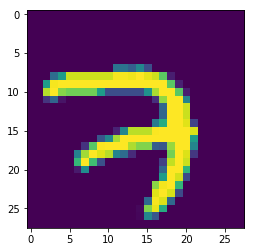

In [78]:
plt.imshow(x.reshape(28, 28))

We see that it is actually a 7. Now let's plot the sub-images.

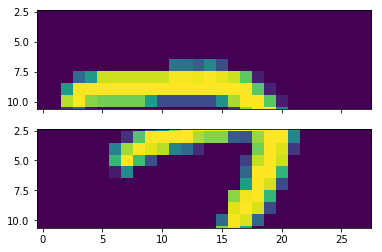

In [79]:
f, axarr = plt.subplots(2, sharex=True)
axarr[0].imshow(x1.reshape(14, 28))
axarr[1].imshow(x2.reshape(14, 28))

The image appears somewhat different, but it is not, as we can see when we put it back together.

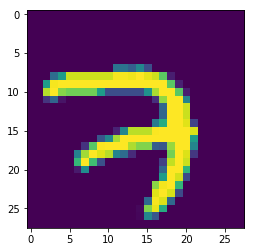

In [80]:
plt.imshow(np.vstack([x1.reshape(14, 28), x2.reshape(14, 28)]))

We create a convenience function to generate training batches of sub-images.

In [81]:
def batch_generator(mnist_input, batch_size):
    n_batches = int(np.ceil(mnist_input.num_examples / batch_size))
    for batch in range(n_batches):
        X_batch, y_batch = mnist_input.next_batch(batch_size)
        X1_batch, X2_batch = np.hsplit(X_batch, 2)
        yield X1_batch, X2_batch, y_batch

## Weight sharing

Next we start building the model. There are many questions and answers on StackOverflow and in other websites concerning the best way to share the weights of a layer. It turns out that for it's particularly easy for the layers of the `tf.layers` module. In our case we have a hidden layer `hidden1` associated with the same name. If we create a second layer, `hidden2`, that has the same name and where the option `reuse` equals `True`, then this will reuse the weights of `hidden1`.

### Weight histogram in TensorBoard

We want to visualize the evolution of the weights of the hidden layer in TensorBoard. The first step is to extract the weights from the corresponding tensor. For each layer, the weights can be accessed by typing: `tf.get_default_graph().get_tensor_by_name('layer_name/kernel:0')`.
We need to assign the content of this tensor to a variable, and create a `tf.summary.histogram` object to access them. Finally we combine all the summaries with `tf.summary.merge_all()`.

In [82]:
he_init = tf.contrib.layers.variance_scaling_initializer()

X1 = tf.placeholder(tf.float32, shape=(None, n_inputs), name='X1')
X2 = tf.placeholder(tf.float32, shape=(None, n_inputs), name='X2')
y = tf.placeholder(tf.int64, shape=(None), name='y')

with tf.name_scope('model'):
    # Here we don't reuse the weights (default)
    hidden1 = tf.layers.dense(X1, n_hidden1, kernel_initializer=he_init,
                              name='hidden1', activation=tf.nn.relu,
                              reuse=None)
    
    weights_hidden1 = tf.get_default_graph().get_tensor_by_name('hidden1/kernel:0')
    tf.summary.histogram('weights_hidden1', weights_hidden1)

    # Here instead we use the weights from `hidden1`.
    hidden2 = tf.layers.dense(X2, n_hidden1, kernel_initializer=he_init,
                              name='hidden1', activation=tf.nn.relu,
                              reuse=True)
    
    # We combine the weight vectors. This should be identical to the weights
    # in `hidden1`. CHECK THAT THIS IS THE CASE
    hidden3 = tf.reduce_mean([hidden1, hidden2], axis=0)
    logits = tf.layers.dense(hidden3, 10, activation=None, name='output')

We then define the loss and create the trainining op. We also create an `accuracy` node to compute the accuracy in the training and in the test set.

In [83]:
with tf.name_scope('loss'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy)

with tf.name_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)
    correct = tf.nn.in_top_k(k=1, predictions=logits, targets=y)
    accuracy = tf.reduce_mean(tf.cast(correct, dtype=tf.float32))

We finally create the variable initializer, the summary node for TensorBoard, and the training and test file writers.

In [84]:
init = tf.global_variables_initializer()

accuracy_summary = tf.summary.scalar('training_accuracy', accuracy)
summaries = tf.summary.merge_all()

train_writer = tf.summary.FileWriter(logdir + '_train', tf.get_default_graph())
test_writer = tf.summary.FileWriter(logdir + '_test', tf.get_default_graph())

We can now create the session and start training.

In [85]:
with tf.Session() as sess:
    sess.run(init)

    step = 0

    X1_test, X2_test = np.hsplit(mnist.test.images, 2)
    y_test = mnist.test.labels

    for epoch in range(n_epochs):
        print('Epoch: ', epoch)
        batchgen_train = batch_generator(mnist.train, batch_size)
        batchgen_test = batch_generator(mnist.test, batch_size)
        for X1_batch, X2_batch, y_batch in batchgen_train:
            sess.run(training_op,
                     feed_dict={X1: X1_batch, X2: X2_batch, y: y_batch})

            if step % 100 == 0:
                train_summ = sess.run(summaries,
                                      feed_dict={X1: X1_batch,
                                                 X2: X2_batch,
                                                 y: y_batch})
                test_summ = sess.run(summaries,
                                     feed_dict={X1: X1_test,
                                                X2: X2_test,
                                                y: y_test})
                train_writer.add_summary(train_summ, step)
                test_writer.add_summary(test_summ, step)
            step += 1

    train_writer.close()
    test_writer.close()

Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Epoch:  10
Epoch:  11
Epoch:  12
Epoch:  13
Epoch:  14
Epoch:  15
Epoch:  16
Epoch:  17
Epoch:  18
Epoch:  19
Epoch:  20
Epoch:  21
Epoch:  22
Epoch:  23
Epoch:  24
Epoch:  25
Epoch:  26
Epoch:  27
Epoch:  28
Epoch:  29
Epoch:  30
Epoch:  31
Epoch:  32
Epoch:  33
Epoch:  34
Epoch:  35
Epoch:  36
Epoch:  37
Epoch:  38
Epoch:  39
Epoch:  40
Epoch:  41
Epoch:  42
Epoch:  43
Epoch:  44
Epoch:  45
Epoch:  46
Epoch:  47
Epoch:  48
Epoch:  49
Epoch:  50
Epoch:  51
Epoch:  52
Epoch:  53
Epoch:  54
Epoch:  55
Epoch:  56
Epoch:  57
Epoch:  58
Epoch:  59
Epoch:  60
Epoch:  61
Epoch:  62
Epoch:  63
Epoch:  64
Epoch:  65
Epoch:  66
Epoch:  67
Epoch:  68
Epoch:  69
Epoch:  70
Epoch:  71
Epoch:  72
Epoch:  73
Epoch:  74
Epoch:  75
Epoch:  76
Epoch:  77
Epoch:  78
Epoch:  79
Epoch:  80
Epoch:  81
Epoch:  82
Epoch:  83
Epoch:  84
Epoch:  85
Epoch:  86
Epoch:  87
Epoch:  88
Epoch:  89
Epoch:  90
Epoch:  9

One can now inspect the performance by running TensorBoard.